# Import libraries and instantiate dataframe

In [1]:
import pandas as pd
import json

frames = []
for i in range(0, 10):
    df = pd.read_json('../data/output/regexlib/output_%s.json' % i)
    frames.append(df)

df = pd.concat(frames)

# Analysis of exceptions

## Create exceptions dataframe

In [2]:
exceptions = df['exception']==True

exceptionsDf = df[exceptions]

exceptionsDf.head()


,exception,regex,matchingInputPairs,nonMatchingInputPairs,outputExceptionStackTrace,inputExceptionStackTrace
6,True,None,None,None,{'message': 'Invalid pattern '([^\w\s\-\_])|(\...,"{'exceptionThrownBy': 'EGRET', 'exception': 'E..."
38,True,None,None,None,{'message': 'Invalid pattern '([ ]?[\\*~`!@#\\...,"{'exceptionThrownBy': 'Python', 'exception': '..."
39,True,None,None,None,{'message': 'Invalid pattern '\\(+\\d{3}|\\d{2...,"{'exceptionThrownBy': 'Python', 'exception': '..."
45,True,None,None,None,{'message': 'Invalid pattern 'href\\s*=\\s*\\\...,"{'exceptionThrownBy': 'Python', 'exception': '..."
75,True,None,None,None,{'message': 'Invalid pattern '(\w+[\.\_\-]*)*\...,None


Normalize exception stacktrace to seperate dataframe for analysis

In [3]:
normalizedExceptionsDf = pd.json_normalize(exceptionsDf['outputExceptionStackTrace'])
normalizedExceptionsDf.head()

,message,regex,source
0,Invalid pattern '([^\w\s\-\_])|(\b\d)|(\b[^a-z...,([^\w\s\-\_])|(\b\d)|(\b[^a-zA-z\-\s]\b)|(\[^a...,System.Text.RegularExpressions
1,Invalid pattern '([ ]?[\\*~`!@#\\%\\^\\*\\(\\)...,([ ]?[\\*~`!@#\\%\\^\\*\\(\\)_\\-\&quot;\&quot...,System.Text.RegularExpressions
2,Invalid pattern '\\(+\\d{3}|\\d{2}|\\d{1}\\)?'...,\\(+\\d{3}|\\d{2}|\\d{1}\\)?,System.Text.RegularExpressions
3,Invalid pattern 'href\\s*=\\s*\\\&quot;((\\/)(...,"href\\s*=\\s*\\\&quot;((\\/)([\\w\\-\\.,@?~\\+...",System.Text.RegularExpressions
4,Invalid pattern '(\w+[\.\_\-]*)*\w+@[\w]+(.)*\...,(\w+[\.\_\-]*)*\w+@[\w]+(.)*\w+$,System.Text.RegularExpressions


In [4]:
import re
def get_sub_category(row):
    x = re.search("(?:[A-Za-z\\(\)'\-{,}+\[\]]+ ){2,5}[A-Za-z\\(\)'){a-z}+\[\]]+.$", row.message)
    if x:
        if 'Unknown property' in x.group(0):
            return 'Unknown property'
        elif 'Reference to undefined group name' in x.group(0):
            return 'Reference to undefined group name'
        elif 'in character range' in x.group(0):
            return 'Cannot include class {x} in character range.'
        else:
            return x.group(0)
    else:
        return None

def get_main_category(row):
    x = re.search("(?:[A-Za-z]+ ){2}", row.message)
    if x: 
        return x.group(0)
    else:
        return None

normalizedExceptionsDf['sub_category'] = normalizedExceptionsDf.apply (lambda row: get_sub_category(row), axis=1)
normalizedExceptionsDf['category'] = normalizedExceptionsDf.apply (lambda row: get_main_category(row), axis=1)

In [5]:
normalizedExceptionsDf['sub_category'].unique().size



12

In [6]:
normalizedExceptionsDf['sub_category'].value_counts().sum()

78

In [7]:
counts = normalizedExceptionsDf['category'].value_counts().to_dict()
counts

{'Invalid pattern ': 94}

In [8]:
normalizedExceptionsDf['sub_category'].value_counts().to_dict()

{'Unrecognized grouping construct.': 35,
 '[x-y] range in reverse order.': 11,
 "Too many )'s.": 10,
 "Not enough )'s.": 7,
 "Nested quantifier '+'.": 4,
 'Unterminated [] set.': 4,
 'Quantifier {x,y} following nothing.': 3,
 'at end of pattern.': 1,
 'named back reference.': 1,
 'must begin with a word character.': 1,
 "Nested quantifier '{'.": 1}

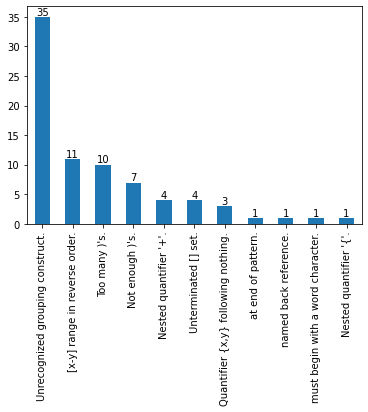

In [9]:
ax = normalizedExceptionsDf['sub_category'].value_counts().plot.bar()
for container in ax.containers:
    ax.bar_label(container)


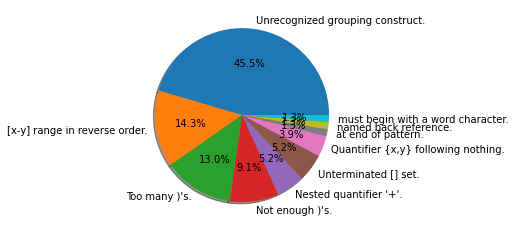

In [10]:
ax = normalizedExceptionsDf['sub_category'].value_counts().head(10).plot.pie(autopct='%1.1f%%',shadow=True, startangle=0)
ax.yaxis.set_visible(False)

## Analysis of Unrecognized grouping construct exception

In [11]:
unrecognized_grouping_construct = normalizedExceptionsDf['sub_category']=='Unrecognized grouping construct.'

unrecognized_grouping_construct_df = normalizedExceptionsDf[unrecognized_grouping_construct]

unrecognized_grouping_construct_df.head(2)

,message,regex,source,sub_category,category
7,Invalid pattern '(?<=select).*(?]from)' at off...,(?<=select).*(?]from),System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern
12,Invalid pattern '(?&lt;HTML&gt;&lt;a[^&gt;]*hr...,(?&lt;HTML&gt;&lt;a[^&gt;]*href\s*=\s*[\&quot;...,System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern


In [12]:
# retrieve regex pattern
def get_grouping_construct(row):
    x = re.search("\(\?[{A-Za-z}*\:]", row.message)
    if x:
        return x.group(0)
    else:
        return None

unrecognized_grouping_construct_df['grouping_construct'] = normalizedExceptionsDf.apply (lambda row: get_grouping_construct(row), axis=1)
unrecognized_grouping_construct_df.head()

/var/folders/1z/wn49xn5j74x5vymtcj4h0fnr0000gp/T/ipykernel_53329/2320901100.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unrecognized_grouping_construct_df['grouping_construct'] = normalizedExceptionsDf.apply (lambda row: get_grouping_construct(row), axis=1)


,message,regex,source,sub_category,category,grouping_construct
7,Invalid pattern '(?<=select).*(?]from)' at off...,(?<=select).*(?]from),System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern,None
12,Invalid pattern '(?&lt;HTML&gt;&lt;a[^&gt;]*hr...,(?&lt;HTML&gt;&lt;a[^&gt;]*href\s*=\s*[\&quot;...,System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern,None
18,Invalid pattern 'href\s*=\s*(?:(?:\&quot;(?&lt...,href\s*=\s*(?:(?:\&quot;(?&lt;url&gt;[^\&quot;...,System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern,(?:
23,Invalid pattern '(?&lt;Day&gt;[1-9]|[0-3][0-9]...,(?&lt;Day&gt;[1-9]|[0-3][0-9])/(?&lt;Month&gt;...,System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern,None
29,Invalid pattern '(?&lt;group5&gt;[0-9]{5})-?(?...,(?&lt;group5&gt;[0-9]{5})-?(?&lt;group4&gt;[0-...,System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern,None


In [13]:
unrecognized_grouping_construct_df.describe()

,message,regex,source,sub_category,category,grouping_construct
count,35,35,35,35,35,13
unique,35,35,1,1,1,5
top,Invalid pattern '(?<=select).*(?]from)' at off...,(?<=select).*(?]from),System.Text.RegularExpressions,Unrecognized grouping construct.,Invalid pattern,(?:
freq,1,1,35,35,35,8


In [14]:
unrecognized_grouping_construct_df['grouping_construct'].value_counts().sum()

13

In [15]:
def is_naming_error(row):
    if row.grouping_construct == None:
        return False
    else:
        return True

unrecognized_grouping_construct_df['is_grouping_construct_naming_error'] = unrecognized_grouping_construct_df.apply (lambda row: is_naming_error(row), axis=1)

/var/folders/1z/wn49xn5j74x5vymtcj4h0fnr0000gp/T/ipykernel_53329/2611618959.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unrecognized_grouping_construct_df['is_grouping_construct_naming_error'] = unrecognized_grouping_construct_df.apply (lambda row: is_naming_error(row), axis=1)


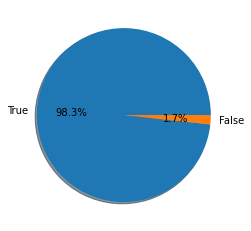

In [108]:
ax = unrecognized_grouping_construct_df['is_grouping_construct_naming_error'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, startangle=0)
ax.yaxis.set_visible(False)

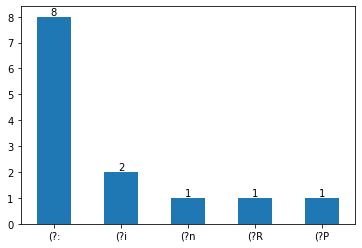

In [16]:
ax = unrecognized_grouping_construct_df['grouping_construct'].value_counts().plot.bar(rot=0)
for container in ax.containers:
    ax.bar_label(container)

## Analysis of Insufficient hexadecimal digits error

In [17]:
insufficient_digits_errors = normalizedExceptionsDf['sub_category']=='Insufficient hexadecimal digits.'

insufficient_digits_error_df = normalizedExceptionsDf[insufficient_digits_errors]

insufficient_digits_error_df.head()

,message,regex,source,sub_category,category


In [18]:
def get_invalid_character(row):
    x = re.search("(\\\\x)|(\\\\u)|(\\\\x)", row.regex)
    if x:
        return x.group(0)
    else:
        return "other character"

insufficient_digits_error_df['invalid_pattern'] = insufficient_digits_error_df.apply (lambda row: get_invalid_character(row), axis=1)
insufficient_digits_error_df.head()

ValueError: Wrong number of items passed 5, placement implies 1

In [115]:
insufficient_digits_error_df['invalid_pattern'].describe()

count     3016
unique       2
top         \x
freq      2810
Name: invalid_pattern, dtype: object

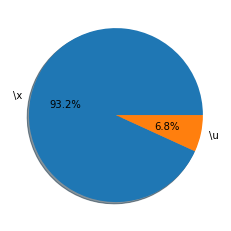

In [113]:
ax = insufficient_digits_error_df['invalid_pattern'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, startangle=0)
ax.yaxis.set_visible(False)

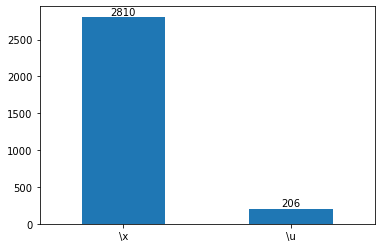

In [93]:
ax = insufficient_digits_error_df['invalid_pattern'].value_counts().plot.bar(rot=0)
for container in ax.containers:
    ax.bar_label(container)


## Analysis of missing closing round bracket
sub category: Not enough )'s 


In [19]:
missing_brackets = normalizedExceptionsDf['sub_category']=="Not enough )'s."

missing_brackets_df = normalizedExceptionsDf[missing_brackets]

missing_brackets_df.head()

,message,regex,source,sub_category,category
6,"Invalid pattern '(/^[A-Z][a-z]*(([\&#39;\,\.\-...","(/^[A-Z][a-z]*(([\&#39;\,\.\-]?[A-Z])?[a-z]*)(...",System.Text.RegularExpressions,Not enough )'s.,Invalid pattern
36,Invalid pattern '^([A-Z]{2}-[A-Z]{2}-[0-9]{2}$...,^([A-Z]{2}-[A-Z]{2}-[0-9]{2}$|^([A-Z]{2}-[0-9]...,System.Text.RegularExpressions,Not enough )'s.,Invalid pattern
39,Invalid pattern '^\$?([0-9](\.[0-9][0-9])?|[1-...,^\$?([0-9](\.[0-9][0-9])?|[1-8][0-9](\.[0-9][0...,System.Text.RegularExpressions,Not enough )'s.,Invalid pattern
63,Invalid pattern 'if(!isValidURL($_POST[&#39;ur...,if(!isValidURL($_POST[&#39;url&#39;]){ echo &q...,System.Text.RegularExpressions,Not enough )'s.,Invalid pattern
77,"Invalid pattern '([*,1-9]:[1-9]){1}(,([*,1-9]:...","([*,1-9]:[1-9]){1}(,([*,1-9]:[1-9]){0,}",System.Text.RegularExpressions,Not enough )'s.,Invalid pattern


In [20]:
missing_brackets_df.describe()

,message,regex,source,sub_category,category
count,7,7,7,7,7
unique,7,7,1,1,1
top,"Invalid pattern '(/^[A-Z][a-z]*(([\&#39;\,\.\-...","(/^[A-Z][a-z]*(([\&#39;\,\.\-]?[A-Z])?[a-z]*)(...",System.Text.RegularExpressions,Not enough )'s.,Invalid pattern
freq,1,1,7,7,7


## Analysis of unknown property exception

In [21]:
unknown_property = normalizedExceptionsDf['sub_category']=="Unknown property"

unknown_property_df = normalizedExceptionsDf[unknown_property]

unknown_property_df.head(20)

,message,regex,source,sub_category,category


In [22]:
regex_pattern = "(\\\\p{[A-Za-z]*})|(\\\\P{[A-Za-z]*})"

def get_invalid_script(row):
    x = re.search(regex_pattern, row.regex)
    if x:
        return x.group(0)
    else:
        return "other character"

unknown_property_df['invalid_pattern'] = unknown_property_df.apply (lambda row: get_invalid_script(row), axis=1)
unknown_property_df['invalid_pattern'].value_counts()

ValueError: Wrong number of items passed 5, placement implies 1

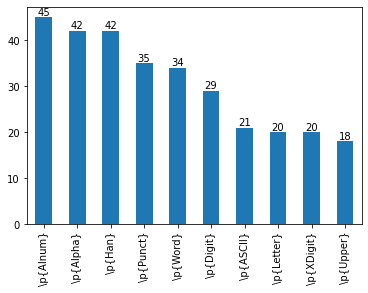

In [35]:
ax = unknown_property_df['invalid_pattern'].value_counts().head(10).plot.bar()

for container in ax.containers:
    ax.bar_label(container)

In [23]:
ax = unknown_property_df['invalid_pattern'].value_counts().head(10).plot.pie(autopct='%1.1f%%',shadow=True, startangle=0)
ax.yaxis.set_visible(False)

KeyError: 'invalid_pattern'

In [49]:
import matplotlib.pyplot as plt
from IPython.display import display
unknown_property_df['invalid_pattern'].value_counts().to_csv('../data/output/unkown_property_exception.csv')


# Analysis of matches and non matches

## Analysis of matching pairs

Here we are iterating over all the matching pairs proposed by Egret. When a False value is found for the match property, it means that a non-match case was found in the list of matches. This means behaviour is different than proposed by Egret.


In [24]:
def return_match_type_matching_pairs(row):

    if row.matchingInputPairs and len(row.matchingInputPairs) > 0: 
        for pair in row.matchingInputPairs:
            if pair['match'] == False:
                return 'Non-matches'
            else:
                return 'Matches'
    else:
        return None

df['match_type_matching_pairs'] = df.apply (lambda row: return_match_type_matching_pairs(row), axis=1)

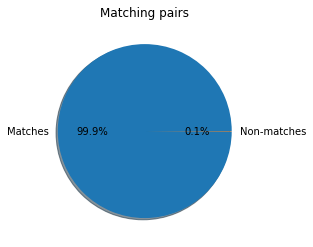

In [25]:
ax = df['match_type_matching_pairs'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, startangle=0)
ax.set_title("Matching pairs")
ax.yaxis.set_visible(False)

In [29]:
df_no_match = df[df['match_type_matching_pairs']=='Non-matches']
df_no_match.head() 
df_no_match.to_json('../data/output/non_matches_regexlib.json')

## Analysis of non matching pairs
In this case, we are iterating over the non-matching input pairs, which contains the non-matches provided by Egret, and the outcome of the .NET's Regex library match() method.

If the property match contains the value of 'True', it means that a match case found. This means that the behaviour is different than Egret proposed.

In [26]:
def return_match_type_non_matching_pairs(row):    
    if row.nonMatchingInputPairs and len(row.nonMatchingInputPairs) > 0: 
        for pair in row.nonMatchingInputPairs:
            if pair['match'] == True:
                return 'Matches'
            else:
                return 'Non-matches'
        
    else:
        return None


df['match_type_non_matching_pairs'] = df.apply (lambda row: return_match_type_non_matching_pairs(row), axis=1)


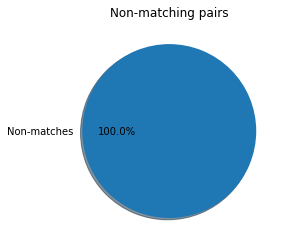

In [27]:
ax = df['match_type_non_matching_pairs'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, startangle=0)
ax.set_title("Non-matching pairs")
ax.yaxis.set_visible(False)
for container in ax.containers:
    ax.set_label(container)

In [4]:
df_no_match = df[df['match_type_non_matching_pairs']=='Matches']
df_no_match.head() 

In [90]:
df_no_match.describe()

,exception,regex,matchingInputPairs,nonMatchingInputPairs,outputExceptionStackTrace,inputExceptionStackTrace,match_type_matching_pairs,match_type_non_matching_pairs
count,7643,7643,7643,7643,0,0,7548,7643
unique,1,7643,6425,5888,0,0,1,1
top,False,"(\d+[.,]?\d*)(\+(\d+[.,]?\d*)){1}i",[],"[{'input': '.0', 'match': True}]",NaN,NaN,Matches,Matches
freq,7643,1,95,63,NaN,NaN,7548,7643


In [88]:
sample = df_no_match.sample(n=10)

In [89]:
sample.to_json('../data/output/samples_non_matching.json')